<p style="font-size:40px; text-align:center">
Computational Physics / Numerische Verfahren in der Physik; SoSe 2023
</p>
<p style="font-size:15px; text-align:center">
Lorenz von Smekal, Ralf-Arno Tripolt, Robin Kehr, Johannes Roth, Leon Sieke
<br>Justus-Liebig-Universität Gießen
</p>
<p style="text-align:center">
<img src="images/JLU_Giessen-Logo.png" width="400" style="background-color: white; padding: 20px; border-radius: 25px;"/>
</p>
<br>
<p style="font-size:30px; color: #3776ab; text-align:center"><b>
Projekt 3: Gezeitenreibung
<b></p>

<p style="font-size:25px; text-align:center">Bearbeitet von Finn Bietz, Florian Adamczyk und Finn Wagner</p>

### Einführung 

In diesem Projekt soll die Gezeitenreibung zwischen Erde und Mond studiert werden. In der folgenden Abbildung ist die Ausprägung zweier Flutberge (der Zenitflutberg ist dem Mond zugewandt, der Nadirflutberg ist dem Mond abgewandt)  skizziert. Diese entstehen durch die Anziehungskraft des Mondes und die Zentrifugalkraft, welche durch die Rotation der Erde um den Schwerpunkt des Erde-Mond Systems erzeugt wird. Da die intrinsische Rotationsperiode der Erde wesentlich kürzer ist als die Umlaufperiode des Mondes, dreht sich die Erde unter den Flutbergen hinweg.

Die dabei entstehende Reibungskraft zwischen den Flutbergen und der mit der Erde rotierenden Materie führt zu einer Verschiebung der Flutberge, so dass sie sich nicht, wie man ohne Reibung erwarten würde, auf der Verbindungslinie des Erd- und Mondmittelpunktes befinden, sondern in Richtung der intrinsischen Erdrotation verschoben sind. Der Zenitflutberg eilt also der Bewegung des Mondes voraus und beschleunigt durch seine Anziehungskraft die Bahnbewegung des Mondes, der sich infolge dessen auf einer größeren Umlaufbahn bewegt. Die intrinsische Rotation der Erde wiederum wird durch die Reibung mit den Flutbergen abgebremst. Diesen Effekt bezeichnet man als Gezeitenreibung. Er ist Gegenstand dieses Projektes. 

<p style="text-align:center">
<img src="images/skizze_gezeitenreibung.png"/>
</p>

Zur Vereinfachung betrachten wir die Gezeitenreibung nur für das Erde-Mond System  und vernachlässigen den Einfluss der Sonne. In der folgenden Zelle befinden sich verschiedene astronomische Größen des Erde-Mond Systems, welche während des Projektes benötigt werden. 

In [89]:
mErde = 5.9721986*10**24        # kg          : Masse der Erde
mOzean = 0.0014*10**24          # kg          : Masse der Ozeane auf der Erde
RErde = 6.3675*10**6            # kg          : Radius der Erde

mMond = 7.3459*10**22           # kg          : Masse des Mondes 
rMondBahn = 3.836*10**8         # m           : Bahnradius des Mondes, die Umlaufbahn des Mondes
                                #               um die Erde kann als Kreisbahn genähert werden
TMondBahn = 27.32166140*24*3600 # s           : Heutige Periodendauer der Mondumlaufbahn um die Erde

TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

G = 6.67430*10**(-11)           # m^3/(kg*s^2): Gravitationskonstante 

In diesem Projekt werden die folgenden Packages benötigt:

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.constants import pi
from scipy.integrate import solve_ivp

### !!!
Wenn ihr auch Lust habt damit rumzuspielen, man kann in Mathjax neue Commands erstellen ;)
$\newline$
Hier sind alle die ich bis jetzt gemacht habe (sieht man nicht). Wenn da Fehler stehen einfach das Notebook nochmal öffnen
$ \renewcommand{\dv}[1]{ \frac{\mathrm{d}}{\mathrm{d} #1}} $ Aus dem Physics package
$ \renewcommand{\Vec}[1]{\overrightarrow{#1}} $


### Leitfragen

#### Zweikörperproblem

- Programmieren Sie eine Funktion, die die gekoppelten Bewegungsgleichungen des Erde-Mond Systems ohne Flutberge mit `solve_ivp()` numerisch für gegebene Anfangsbedingungen löst. Dabei sollte die Masse $m_i$ und die Anfangsbedingungen jedes Körpers der Funktion als Liste übergeben werden. Zudem soll die Zeit $t_\mathrm{max}$, bis zu der die Lösungen bestimmt werden, übergeben werden. Die Funktion sollte eine Liste mit interpolierten Bahnkurven [$x_i(t),y_i(t)$] zurückgeben.
    - Beschränken Sie das Problem auf die x-y-Ebene und behandeln Sie die beiden Körper als Punktmassen, die intrinsische Rotation der Erde soll also zunächst vernachlässigt werden.

$ \newcommand{\dv}[1]{ \frac{\mathrm{d}}{\mathrm{d} #1}} $
$ \newcommand{\Vec}[1]{\overrightarrow{#1}} $

Es handelt sich hier um das klassiche Zweikörperproblem, dass zuerst von Johannes Kepler angegeben und zuerst analytisch von Isaac Newton gelöst wurde.
$\newline$
Da hier zwei Körper eine Rolle spielen stellen wir zwei DGL auf:
\begin{align}
    m_1 \Vec{\ddot{z_1}} &= \Vec{F_{1,2}} \\
    m_2 \Vec{\ddot{z_2}} &= \Vec{F_{2,1}}
\end{align}
$\vec{F_{2,1}}$ steht hier für die Kraft, die die beiden Körper anzieht.
Hier handelt es sich natürlich um die Schwerkraft
\begin{gather}
    \Vec F_1 = G \frac{m_1 \cdot m_2}{r^2} \Vec e_{12} \\
    \mathrm{mit} \ r := \left| \Vec{z_2} - \Vec{z_1} \right|
\end{gather}
Zusätzlich gilt nach dem 3.ten Newtonschen Gesetz
\begin{equation}
    \Vec{F_{1,2}} = -\Vec{F_{2,1}}
\end{equation}
Wir setzen das Gravitationsgesetz nun in unsere DGL's ein und erhalten
\begin{align}
    \ddot{z_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{z_2} - \Vec{z_1} \right| \right) }^3} \cdot \left( \Vec{z_2} - \Vec{z_1} \right) \\
    \ddot{z_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{z_2} - \Vec{z_1} \right| \right) }^3} \cdot \left( \Vec{z_1} - \Vec{z_2} \right)
\end{align}
Wir erhalten also vier Gleichungen
\begin{align}
    \ddot{x_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_2 - x_1 \right) \\
    \ddot{y_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( y_2 - y_1 \right) \\
    \ddot{x_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_1 - x_2 \right) \\
    \ddot{y_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( y_2 - y_1 \right) \\
\end{align}

Die Methode `solve_ivp()` kann keine Differentialgleichungen $n$-ter Ordnung lösen.
Wir formen deshalb unser Problem in ein DGL-System erster Ordnung um.
$\newline$
Dazu führen wir eine neue Variable $v$ und $a$ ein.
\begin{gather}
    \dv{t} x_1(t) = v_1(t) \\
    \dv{t} v_1(t) = \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_2 - x_1 \right) \\
\end{gather}
Dieses verfahren wenden wir äquivalent für die anderen drei Gleichungen an.

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.012e+00 ...  2.360e+07  2.361e+07]
        y: [[ 0.000e+00  1.707e-05 ...  2.600e+06  2.614e+06]
            [ 0.000e+00  3.373e-05 ...  1.121e+01  1.123e+01]
            ...
            [ 0.000e+00  1.034e+03 ...  6.306e+08  6.312e+08]
            [ 1.021e+03  1.021e+03 ...  4.556e+02  4.526e+02]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f87539fed10>
 t_events: None
 y_events: None
     nfev: 60026
     njev: 0
      nlu: 0


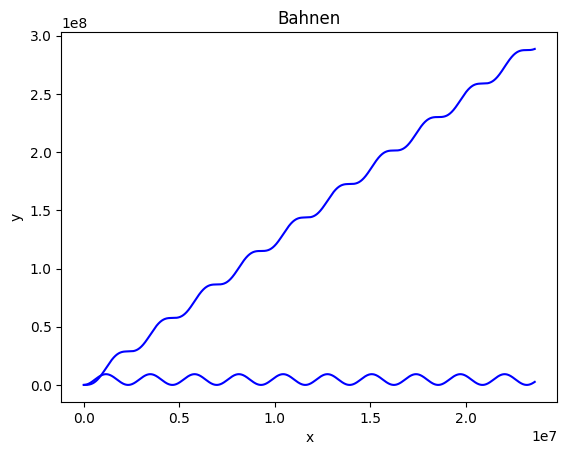

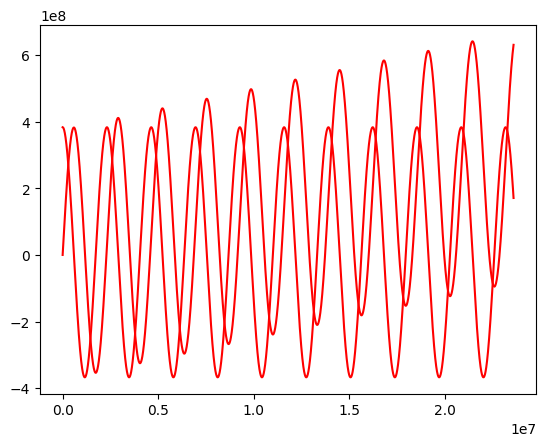

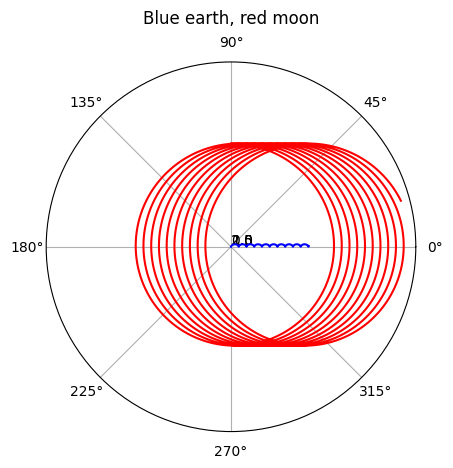

In [106]:
m_1 = mErde
m_2 = mMond
mass = [m_1, m_2]
x = [0, rMondBahn]
y = [0, 0]
v_x = [0, 0]
v_y = [0, 2*pi*rMondBahn/TMondBahn]
# https://stackoverflow.com/questions/59634279/solve-ivp-error-required-step-size-is-less-than-spacing-between-numbers

# The function acutally passed to solve_ivp
def derivatives(t, state):
    x_1 = state[0]
    v_x_1 = state[1]
    x_2 = state[2]
    v_x_2 = state[3]
    y_1 = state[4]
    v_y_1 = state[5]
    y_2 = state[6]
    v_y_2 = state[7]
    r = ((x_2 - x_1)**2 + (y_2 - y_1)**2 )**0.5
    # print(f'State: vx: {v_x_1}, a_x: {G * mass[1] / (r**3) * (x_2 - x_1)}, vy: {v_y}, a_y: {G * mass[1] / (r**3) * (y_2 - y_1)}')
    return [v_x_1,
            G * mass[1] / (r**3) * (x_2 - x_1),
            v_x_2,
            G * mass[0] / (r**3) * (x_1 - x_2),
            v_y_1,
            G * mass[1] / (r**3) * (y_2 - y_1),
            v_y_2,
            G * mass[0] / (r**3) * (y_1 - y_2)
            ]
    gravit = G*(pos[1]-pos[0])/norme*ipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
def two_body_problem(mass: list, x: list, y: list, v_x: list, v_y: list, t_max: float, t_start=0):
    # mass: contains the masses of the bodys
    # x: contains the strarting x coordinates of the bodys
    # y: contains the strarting y coordinates of the bodys
    # v_x: contains the strarting x-velocities of the bodys
    # v_y: contains the strarting y-velocities of the bodys

    # We need to add tolearances because the values are very large
    # dense_output makes 
    sol = solve_ivp(derivatives, [t_start, t_max], [x[0], v_x[0], x[1], v_x[1], y[0], v_y[0], y[1], v_y[1]], dense_output=True, atol=1e-4*rMondBahn, max_step=TMondBahn/1000)
    
    # return liste mit interpolierten Bahnkurven [x_i, y_i]
    
    # Solution
    print(sol)

    # Chosen time points
    # print('Chosen time points')
    # print(sol.t)

    # Masse 1 (Erde)
    #print(f'x1-Werte Erde {sol.y[0]}')
    #print(f'y1-Werte Erde {sol.y[4]}')
    # Masse 2 (Mond)
    #print(f'x2-Werte Mond {sol.y[2]}')
    #print(f'y2-Werte Mond {sol.y[6]}')
    return sol

sol = two_body_problem(mass, x, y, v_x, v_y, 10*TMondBahn)

# Plot der beiden Bahnen
plt.title('Bahnen')
plt.xlabel("x")
plt.ylabel("y")

t = sol.t
x_1_values = sol.y[0]
v_x_1_values = sol.y[1]
x_2_values = sol.y[2]
v_x_2_values = sol.y[3]
y_1_values = sol.y[4]
v_y_1_values = sol.y[5]
y_2_values = sol.y[6]
v_y_2_values = sol.y[7]

plt.plot(t, x_1_values, color='blue')
plt.plot(t, y_1_values, color='blue')

plt.show()
plt.plot(t, x_2_values, color='red')
plt.plot(t, y_2_values, color='red')

r = lambda x, y: np.sqrt(x**2 + y**2)
theta = lambda x, y: np.arctan2(x, y)

# Polar Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta(x_1_values, y_1_values), r(x_1_values, y_1_values), color='blue')
ax.plot(theta(x_2_values, y_2_values), r(x_2_values, y_2_values), color='red')
# ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Blue earth, red moon", va='bottom')
plt.show()

Wir wollen diese Lösung mit Hilfe der exakten analytischen Lösung überprüfen.
Hier analytische Lösung :)

- Erstellen Sie verschiedene Plots, die die Zeitentwicklung am besten illustrieren, z.B. parametrische Plots der Bahnen beider Körper oder geeignete Phasenraumplots. 
    - Wählen Sie dabei die Anfangsbedingungen so, dass der Schwerpunkt des Zweiteilchensystems im Ursprung ruht.

- Betrachten Sie die zeitliche Entwicklung des Schwerpunktes. Wie sollte seine Bahn in einem abgeschlossenem System verlaufen und ist dies tatsächlich der Fall? 
$\newline$
- Implementieren Sie das explizite Euler-Verfahren und das explizite Runge-Kutta-Verfahren 4. Ordnung aus der Vorlesung. 
$\newline$
- Lösen Sie mit Ihren Implementierungen die Bewegungsgleichungen des Erde-Mond-Systems erneut. Vergleichen Sie die Ergebnisse untereinander und mit dem Ergebnis der obigen Funktion. Vergleichen Sie alle Ergebnisse auch mit der exakten Lösung des Zweikörperproblems.

#### Vierkörperproblem mit Randbedingungen

- Erweitern Sie die obige Funktion um die beiden Flutberge, die sich auf der Erdoberfläche befinden.
    - Dazu werden die beiden Flutberge als Punktmassen genähert, dessen Abstand zur Erde zu jeder Zeit dem Erdradius entspricht. Aufgrund dieser Zwangsbedingungen gestaltet sich die Herleitung der Bewegungsgleichungen als kompliziert. 
        
        Sei $\vec F_{ba}$ die Gravitationskraft, die ein Körper $b$ auf einen Körper $a$ ausübt. Die gegenseitige Gravitationskraft der beiden Flutberge ist sehr gering und wird daher im Folgenden vernachlässigt, d.h. $\vec F_{21}$=$\vec F_{12}=0$. 
        
        Die radiale Kompenente der Kraft auf die beiden Flutberge muss so festgesetzt werden, dass ihr jeweiliger Abstand zur Erde gleich bleibt, also zu jeder Zeit dem Erdradius entspricht. Dies wird mit dem Einführen von radial gerichteten Zwangskräften bewerkstelligt. Da die Gravitationskraft von der Erde auf die Flutberge ebenfalls radial gerichtet ist, kann diese implizit in die Definition der Zwangskräfte mit eingebaut werden, $\vec F_{\mathrm{Z}1}$ und $\vec F_{\mathrm{Z}2}$ stellen also die Summe der jeweiligen Zwangskraft und der Gravitationskraft der Erde auf Flutberg 1 bzw. Flutberg 2 dar. Auf die Erde wirken diese Kräfte mit entgegengesetztem Vorzeichen. 
        
        Damit ergibt sich für die Gesamtkräfte $\vec F_\mathrm{E}$, $\vec F_\mathrm{M}$, $\vec F_1$, $\vec F_2$ auf Erde, Mond, Flutberg 1 bzw. Flutberg 2 folgendes Gleichungssystem:
$\newline$
\begin{align*}
    \vec F_\mathrm{E} &= \vec F_\mathrm{ME} - \vec F_{\mathrm{Z}1} - \vec F_{\mathrm{Z}2} \\
    \vec F_\mathrm{M} &= \vec F_\mathrm{EM} + \vec F_{1\mathrm{M}} + \vec F_{2\mathrm{M}} \\
    \vec F_1 &=  \vec F_{\mathrm{M}1} + \vec F_{\mathrm{Z}1}     \\
    \vec F_2 &= \vec F_{\mathrm{M}2} + \vec F_{\mathrm{Z}2} \,.        
\end{align*}

    Die Koordinaten des $i$-ten Flutbergs lassen sich am elegantesten in Polarkoordinaten relativ zu den Erdkoordinaten $\vec r_\mathrm{E}$ angeben:
$\newline$
\begin{equation*}
    \vec r_i = \vec r_\mathrm{E} + R_\mathrm{E}\,\vec e_{r,i}\,,
\end{equation*}

    wobei $\vec e_{r,i}$ den radialen Einheitsvektor in Bezug auf den $i$-ten Flutberg darstellt. Die Kraft auf den $i$-ten Flutberg lässt sich nun in einen radialen Anteil und einen Winkelanteil aufteilen:
$\newline$
\begin{align*}
    \vec F_i &= (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} + (\vec F_{\mathrm{M}i})_{r,i} \vec e_{r,i} + F_{\mathrm{Z}i} \vec e_{r,i} \\
    &= (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} + ((\vec F_{\mathrm{M}i})_{r,i} + F_{\mathrm{Z}i})\, \vec e_{r,i}\,. 
\end{align*}

    Hierbei stellt $\vec e_{\varphi,i}$ den Einheitsvektor in $\varphi_i$-Richtung und $\varphi_i$ den Winkel des $i$-ten Flutbergs relativ zu den Erdkoordinaten dar. Die Beschleunigung des $i$-ten Flutberg in Richtung Erde muss der Zentripetalbeschleunigung für stabile Kreisbahnen abzüglich der Beschleunigung der Erde in radiale Richtung betragen, damit die Zwangsbedingung (ZB) erfüllt ist, d.h.
$\newline$
\begin{equation*}
    (\vec F_{\mathrm{M}i})_{r,i} + F_{\mathrm{Z}i} \stackrel{\mathrm{ZB}}{=} -m_i \left( R_\mathrm{E} \dot{\varphi}_i^2 - (\ddot{\vec r_\mathrm{E}})_{r,i} \right)\,,
\end{equation*}

    wobei $m_i$ die Masse des $i$-ten Flutbergs ist. 
    
    Dies lässt sich mit einer Analogie zum Fadenpendel verstehen, wobei die Masse am Pendel einem Flutberg bzw. der Aufhängepunkt der Erde entspricht. Jedoch muss hier zusätzlich berücksichtigt werden, dass die Erde im Gegensatz zum Aufhängepunkt beim Fadenpendel zusätzlich beschleunigt werden kann, weshalb die Beschleunigung der Erde in radiale Richtung von der Zentripetalbeschleunigung subtrahiert werden muss. So wird zum Beispiel die Zwangsbedingung bereits eingehalten, wenn die Erde in Richtung eines Flutbergs mit dem Betrag der Zentripetalbeschleunigung beschleunigt wird und auf den Flutberg keine radiale Beschleunigung wirkt. 
 
    Aus den Kräftgleichungen lassen sich nun die benötigten Bewegungsgleichungen ablesen. Beachten Sie, dass die Gleichungen für die Flutberge jeweils nur eine Bewegungsgleichung bezüglich des jeweiligen Winkels liefern, während die Bewegungsgleichung bezüglich der radialen Koordinate aufgrund der Zwangsbedingung redundant ist. Im Gegensatz zu dieser Herleitung mit Newtonscher Mechanik lassen sich die Bewegungsgleichungen wesentlich leichter mit dem Lagrangeformalismus, welcher die Zwangsbedingungen auf eine natürliche Art implementiert, herleiten.
$\newline$    
- Betrachten Sie die zeitliche Entwicklung des Vierteilchensystems.
    - Teilen Sie dabei zunächst die Masse der Ozeane auf die beiden Flutberge gleichmäßig auf und lassen Sie die beiden Flutberge auf der Verbindungslinie zwischen Erde und Mond mit der Umlaufperiodendauer des Mondes starten. Passen Sie die Anfangsbedingungen so an, dass der Schwerpunkt wieder im Ursprung ruht.
    - Fertigen Sie eine Grafik/Animation an, in der die Erde, der Mond und die Flutberge in Abhängigkeit der Zeit und in der $x$-$y$-Ebene dargestellt werden.

#### Vierkörperproblem mit Randbedingungen, intrinsischer Rotation und Reibung

- Erweitern Sie Ihre Funktion abermals und berücksichtigen Sie nun auch die Reibung zwischen den Flutbergen und dem übrigen Teil der Erde sowie die intrinsische Rotation der Erde, welche sich durch die Reibungskraft $\vec F_{\mathrm R}$ ändert.
    - Verwenden Sie als Reibungskraft, die auf den i-ten Flutberg wirkt, $ \vec F_{\mathrm R,i}(\vec v_i)=-km_i|\vec v_i| \vec v_i\,,$ hierbei ist $\vec v_i$ die Geschwindigkeit des $i$-ten Flutbergs relativ zur rotierenden Erdoberfläche und $k$ eine effektive Reibungskonstante. Wählen Sie im folgenden $k=2\cdot10^{-12}\,\frac{1}{\mathrm m}$.
    - Leiten Sie die Bewegungsgleichung für die intrinsische Erdrotation aus der Drehimpulsrelation $L=I \omega$ her. Hierbei ist $\omega$ die Winkelgeschwindigkeit der Eigenrotation und $I$ das Trägheitsmoment der Erde, wobei die Erde diesbezüglich als Kugel mit homogener Massenverteilung betrachtet werden soll (in den anderen Bewegungsgleichungen aber weiterhin als Punktmasse). Geben Sie die Beziehung zwischen dem auf die Erde wirkenden Drehmoment $M$ und der Zeitableitung $\dot\omega$ an, die daraus folgt. Bestimmen Sie $M$ aus den Reibungskräften, um daraus die Bewegungsgleichung für die intrinsische Erdrotation zu erhalten.
    - Zusätzlich müssen Sie die Bewegungsgleichungen der Flutberge anpassen, indem Sie die entsprechende Reibungskraft in die Kräftgleichung mit einbauen.
$\newline$
- Betrachten Sie wieder die zeitliche Entwicklung des Vierteilchensystems und erstellen Sie eine Grafik/Animation der beteiligten Körper in Abhängigkeit der Zeit und in der $x$-$y$-Ebene. Vergleichen Sie die Bewegung der Flutberge mit und ohne Reibung. Illustrieren Sie einen möglichen Unterschied beider Bewegungen.
$\newline$
- Fitten Sie die Massen der Flutberge, so dass die aktuelle Zunahme der Tageslänge pro 100 Jahre mit dem oben angegebenen Literaturwert $\tau$ übereinstimmt. Weichen die gefitteten Massen der Flutberge von der Masse der Ozeane ab? Geben Sie mögliche Gründe für die Abweichungen an.
    - Wählen Sie die Massen der beiden Flutberge gleich groß. Falls Sie die Flutberge wieder auf der Verbindungslinie zwischen Erde und Mond mit der Umlaufperiodendauer des Mondes starten lassen, berücksichtigen Sie die Einschwingzeit des Systems, bevor Sie die Tageslängenänderung bestimmen.

### Weiterführende Untersuchungen 

#### Variation der Reibungskonstante

- Können Sie die Reibungskonstante $k$ so fitten, dass die Gesamtmasse der Flutberge der Masse der Ozeane entspricht und auch $\tau$ mit dem Literaturwert übereinstimmt? Was beobachten Sie für diesen Fall im zeitlichen Verlauf?

#### Vielteilchenproblem mit Randbedingungen, intrinsischer Rotation und Reibung

- Verwenden Sie statt nur zwei Flutbergen nun eine Vielzahl von Punktmassen, die Sie auf der Erdoberfläche verteilen. Die Punktmassen simulieren nun die Wassermassen auf der Erdoberfläche. Können Sie die Ausprägung der beiden Flutberge beobachten?  Damit das Lösen der Differentialgleichungen nicht zu aufwändig wird, benötigen Sie eine Näherung. Nehmen Sie hierzu an, dass die Masse der Erde viel größer als die Masse der Flutberge ist. Ersetzen Sie die Bewegungsgleichungen der Erd- und Mondkoordinaten durch jene aus dem System, das nur aus Erde und Mond besteht. Argumentieren Sie, ob die Näherung gerechtfertigt ist oder nicht.
$\newline$
- Betrachten Sie wieder den Fall von zwei Flutbergen und lösen Sie die Differentialgleichungen im genäherten Fall. Vergleichen Sie diese Lösung mit der Lösung aus dem exakten Fall von oben. Ist die Näherung gerechtfertigt?